In [1]:
import torch
import numpy as np
from sae_lens import SAE, HookedSAETransformer
import pandas as pd
from torch import nn
import ezkl
import os
import json
import time
#from sae_lens.toolkit.neuronpedia_integration import get_feature_from_neuronpedia


/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Circuit(nn.Module):
    def __init__(self):
        super(Circuit, self).__init__()

    def forward(self, users, balances, total):
        nil = torch.nn.Parameter(torch.tensor([0.0]))
        # calculate the total balance across all users second term will be ignored by the optimizer but will force it to be included in a separate col for commitment
        balances = torch.sum(balances, dim=1) + nil * users
        # now check if the total balance is less than the total
        return (balances[:,0] <= total)


circuit = Circuit()


In [3]:
model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.compiled')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')

witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

In [4]:
user_preimages = [0.0, 1.0, 2.0, 3.0, 4.0, 9.0]
balances = torch.tensor([0, 2, 3, 4, 5, 10])
balances = balances.reshape(1, 6)


# Create an empty list to store the hashes of float -- which I guess we'll call the users here
users = []

# Loop through each element in the y tensor
for e in user_preimages:
    # Apply the custom function and append the result to the list
    users.append(ezkl.poseidon_hash([ezkl.float_to_felt(e, 0)])[0])

users_t = torch.tensor(user_preimages)
users_t = users_t.reshape(1, 6)

total = torch.tensor([25])
total = total.reshape(1, 1)

# Flips thegraph into inference mode
circuit.eval()

    # Export the model
torch.onnx.export(circuit,               # model being run
                      (users_t,balances,total),                   # model input (or a tuple for multiple inputs)
                      model_path,            # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=17,          # the ONNX version to export the model to
                      do_constant_folding=False,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})


    
data_array_x = users
data_array_y = ((balances).detach().numpy()).reshape([-1]).tolist()
data_array_z = ((total).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array_x, data_array_y, data_array_z])


    # Serialize data into file:
json.dump( data, open(data_path, 'w' ))


/state/partition1/job-60084051/ipykernel_2668043/1845078605.py:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nil = torch.nn.Parameter(torch.tensor([0.0]))


In [2]:
class FreivaldsVerificationSAE(SAE):
    def __init__(self, cfg, features_to_check=None, num_trials=10, tol=0.01):
        super().__init__(cfg)
        self.features_to_check = [2592, 4445, 4663, 4733, 6531, 8179, 9566, 20927, 24185]   # List of feature indices to check
        self.num_trials = num_trials
        self.tol = tol
        self.feature_present = False

    def encode_standard(self, x):
        # Use the original encode function
        feature_acts = super().encode_standard(x)

        print(feature_acts.shape)

        # Store the feature activations for later verification
        self._last_feature_acts = feature_acts

        for feature_idx in self.features_to_check:
            # Create a copy of feature activations with the target feature zeroed out
            modified_acts = feature_acts.clone()
            modified_acts[:, :, feature_idx] = 0
    
        
        return feature_acts
    
    def decode(self, feature_acts):
        # Use the original decode function to get the reconstruction
        sae_out = super().decode(feature_acts)

        sae_out_preact = self.apply_finetuning_scaling_factor(feature_acts) @ self.W_dec + self.b_dec
        # print("preact shape", sae_out_preact.shape)
        
        # Verify specific features using Freivalds' algorithm
        # if self.features_to_check is not None:
        self.verify_features(feature_acts, sae_out_preact)
            
        return sae_out
    
    def verify_features(self, feature_acts, sae_out_preact):
        """Verifies if specific features contribute to the reconstruction using Freivalds' algorithm."""
        batch_size, seq_len, d_sae = feature_acts.shape
        d_in = self.W_dec.shape[-1]
        # print("Preact shape", sae_out_preact.shape)
        
        
        for feature_idx in self.features_to_check:
            # Create a copy of feature activations with the target feature zeroed out
            modified_acts = feature_acts.clone()
            modified_acts[:, :, feature_idx] = 0
            
            # Check if reconstruction changes significantly using Freivalds
            self.feature_present += self.freivalds_verify_reconstruction(
                feature_acts, modified_acts, sae_out_preact
            )
        

    def freivalds_verify_reconstruction(self, original_acts, modified_acts, sae_out_preact, num_trials=None, tol=None):
        """
        Freivalds' verification integrated into SAE class
        """
        d_in = self.W_dec.shape[-1]

        # batch_size, seq_len, d_sae = feature_acts.shape
        # print("Shape SAE out:", sae_out_preact.shape)
        # print("Shape Preact SAE out:", sae_out_preact.shape)
        # print("Shape Decoder Bias:", self.b_dec.shape)
        # print("Shape Feature activations:", self.apply_finetuning_scaling_factor(feature_acts).shape)
        # print("Shape Decoder Weights:", self.W_dec.shape)
        # print(f'Seeking:{sae_out_preact - self.b_dec - self.apply_finetuning_scaling_factor(feature_acts) @ self.W_dec}')
        
        for _ in range(self.num_trials):
            r = torch.randint(0, 2, (d_in, 1), 
                            dtype=modified_acts.dtype, 
                            device=modified_acts.device)
            
            # Compute both sides of equation
            Cr = (sae_out_preact - self.b_dec) @ r
            Br = self.W_dec @ r
            ABr = self.apply_finetuning_scaling_factor(modified_acts) @ Br
            # print("Original", torch.norm((self.apply_finetuning_scaling_factor(original_acts) @ Br) - Cr))
            # print("Modified", torch.norm(ABr - Cr))
            
            if torch.norm(ABr - Cr, p=float('inf')) > self.tol:
                return True
        return False


In [3]:
model = HookedSAETransformer.from_pretrained("gpt2-small", device="cpu")

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.
sae, cfg_dict, sparsity = FreivaldsVerificationSAE.from_pretrained(
    release="gpt2-small-res-jb",  # <- Release name
    sae_id="blocks.7.hook_resid_pre",  # <- SAE id (not always a hook point!)
    device="cpu",
)

Loaded pretrained model gpt2-small into HookedTransformer


/ext3/miniforge3/lib/python3.12/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [32]:
print(sae.cfg.__dict__)

{'architecture': 'standard', 'd_in': 768, 'd_sae': 24576, 'activation_fn_str': 'relu', 'apply_b_dec_to_input': True, 'finetuning_scaling_factor': False, 'context_size': 128, 'model_name': 'gpt2-small', 'hook_name': 'blocks.7.hook_resid_pre', 'hook_layer': 7, 'hook_head_index': None, 'prepend_bos': True, 'dataset_path': 'Skylion007/openwebtext', 'dataset_trust_remote_code': True, 'normalize_activations': 'none', 'dtype': 'torch.float32', 'device': 'cpu', 'sae_lens_training_version': None, 'activation_fn_kwargs': {}, 'neuronpedia_id': 'gpt2-small/7-res-jb', 'model_from_pretrained_kwargs': {'center_writing_weights': True}, 'seqpos_slice': (None,)}


In [4]:
print(model)  # Or:
print(model.cfg)

HookedSAETransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
     

In [158]:
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset(
    path="NeelNanda/pile-10k",
    split="train",
    streaming=False,
)

token_dataset = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=model.tokenizer,  # type: ignore
    streaming=True,
    max_length=sae.cfg.context_size,
    add_bos_token=sae.cfg.prepend_bos,
)

In [115]:
import requests

url = "https://www.neuronpedia.org/api/explanation/export?modelId=gpt2-small&saeId=7-res-jb"
headers = {"Content-Type": "application/json"}

response = requests.get(url, headers=headers)

In [25]:
# convert to pandas
data = response.json()
explanations_df = pd.DataFrame(data)
# rename index to "feature"
explanations_df.rename(columns={"index": "feature"}, inplace=True)
# explanations_df["feature"] = explanations_df["feature"].astype(int)
explanations_df["description"] = explanations_df["description"].apply(
    lambda x: x.lower()
)
explanations_df

,modelId,layer,feature,description,explanationModelName,typeName
0,gpt2-small,7-res-jb,218,stars and dashed for censoring expletives,None,oai_token-act-pair
1,gpt2-small,7-res-jb,218,stars and dashes for censoring expletives,None,oai_token-act-pair
2,gpt2-small,7-res-jb,218,offensive language and expletives,None,oai_token-act-pair
3,gpt2-small,7-res-jb,2020,names of people,gpt-3.5-turbo,oai_token-act-pair
4,gpt2-small,7-res-jb,3493,references to nazism,gpt-3.5-turbo,oai_token-act-pair
...,...,...,...,...,...,...
24568,gpt2-small,7-res-jb,24571,locations and cities paired with information s...,gpt-3.5-turbo,oai_token-act-pair
24569,gpt2-small,7-res-jb,24572,"actions related to personal grooming, such as ...",gpt-3.5-turbo,oai_token-act-pair
24570,gpt2-small,7-res-jb,24573,"words containing the sequence ""lo""",gpt-3.5-turbo,oai_token-act-pair
24571,gpt2-small,7-res-jb,24574,instances of added or inserted text,gpt-3.5-turbo,oai_token-act-pair


In [26]:
bible_features = explanations_df.loc[explanations_df.description.str.contains(" bible")]
bible_features

,modelId,layer,feature,description,explanationModelName,typeName
11902,gpt2-small,7-res-jb,11735,"references to religious texts, particularly th...",gpt-3.5-turbo,oai_token-act-pair


In [33]:
from transformer_lens.utils import test_prompt

prompt = "How do i live my life"
promp2 = "Today is weekend, tomorrow is"
answer = "Monday"

# Show that the model can confidently predict the next token.
test_prompt(promp2, answer, model)

Tokenized prompt: ['<|endoftext|>', 'Today', ' is', ' weekend', ',', ' tomorrow', ' is']
Tokenized answer: [' Monday']


Performance on answer token:
Rank: 0        Logit: 13.96 Prob:  8.18% Token: | Monday|

Top 0th token. Logit: 13.96 Prob:  8.18% Token: | Monday|
Top 1th token. Logit: 13.85 Prob:  7.39% Token: | Saturday|
Top 2th token. Logit: 13.67 Prob:  6.15% Token: | Sunday|
Top 3th token. Logit: 13.63 Prob:  5.89% Token: | weekend|
Top 4th token. Logit: 13.34 Prob:  4.43% Token: | the|
Top 5th token. Logit: 12.85 Prob:  2.70% Token: | week|
Top 6th token. Logit: 12.70 Prob:  2.34% Token: | day|
Top 7th token. Logit: 12.67 Prob:  2.27% Token: | Friday|
Top 8th token. Logit: 12.58 Prob:  2.07% Token: | holiday|
Top 9th token. Logit: 12.56 Prob:  2.02% Token: | a|


Ranks of the answer tokens: [(' Monday', 0)]

In [34]:
sae.use_error_term

False

In [35]:
# hooked SAE Transformer will enable us to get the feature activations from the SAE
sae.feature_present = 0
_, cache = model.run_with_cache_with_saes(prompt, saes=[sae])

print([(k, v.shape) for k, v in cache.items() if "sae" in k])

# note there were 11 tokens in our prompt, the residual stream dimension is 768, and the number of SAE features is 768

torch.Size([1, 7, 24576])
[('blocks.7.hook_resid_pre.hook_sae_input', torch.Size([1, 7, 768])), ('blocks.7.hook_resid_pre.hook_sae_acts_pre', torch.Size([1, 7, 24576])), ('blocks.7.hook_resid_pre.hook_sae_acts_post', torch.Size([1, 7, 24576])), ('blocks.7.hook_resid_pre.hook_sae_recons', torch.Size([1, 7, 768])), ('blocks.7.hook_resid_pre.hook_sae_output', torch.Size([1, 7, 768]))]


In [36]:
sae.feature_present

0

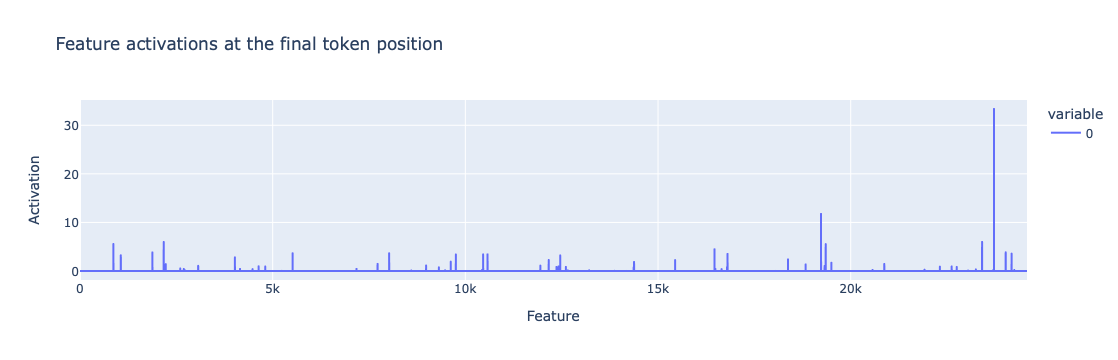

Feature 23718 fired 33.34
Feature 19230 fired 11.74
Feature 23409 fired 5.98
Feature 2172 fired 5.98
Feature 867 fired 5.55


In [154]:
# let's look at which features fired at layer 8 at the final token position
import plotly.express as px
# hover over lines to see the Feature ID.
px.line(
    cache["blocks.7.hook_resid_pre.hook_sae_acts_post"][0, -1, :].cpu().numpy(),
    title="Feature activations at the final token position",
    labels={"index": "Feature", "value": "Activation"},
).show()

# let's print the top 5 features and how much they fired
vals, inds = torch.topk(
    cache["blocks.7.hook_resid_pre.hook_sae_acts_post"][0, -1, :], 5
)
for val, ind in zip(vals, inds):
    print(f"Feature {ind} fired {val:.2f}")
    # html = get_dashboard_html(
    #     sae_release="gpt2-small", sae_id="7-res-jb", feature_idx=ind
    # )
    # display(IFrame(html, width=1200, height=300))

In [12]:
# instantiate an object to hold activations from a dataset
from sae_lens import ActivationsStore

# a convenient way to instantiate an activation store is to use the from_sae method
activation_store = ActivationsStore.from_sae(
    model=model,
    sae=sae,
    streaming=True,
    # fairly conservative parameters here so can use same for larger
    # models without running out of memory.
    store_batch_size_prompts=8,
    train_batch_size_tokens=4096,
    n_batches_in_buffer=32,
    device="cpu",
)

/ext3/miniforge3/lib/python3.12/site-packages/sae_lens/training/activations_store.py:301: UserWarning:

Dataset is not tokenized. Pre-tokenizing will improve performance and allows for more control over special tokens. See https://jbloomaus.github.io/SAELens/training_saes/#pretokenizing-datasets for more info.



In [13]:
def list_flatten(nested_list):
    return [x for y in nested_list for x in y]


# A very handy function Neel wrote to get context around a feature activation
def make_token_df(tokens, len_prefix=5, len_suffix=3, model=model):
    str_tokens = [model.to_str_tokens(t) for t in tokens]
    unique_token = [
        [f"{s}/{i}" for i, s in enumerate(str_tok)] for str_tok in str_tokens
    ]

    context = []
    prompt = []
    pos = []
    label = []
    for b in range(tokens.shape[0]):
        for p in range(tokens.shape[1]):
            prefix = "".join(str_tokens[b][max(0, p - len_prefix) : p])
            if p == tokens.shape[1] - 1:
                suffix = ""
            else:
                suffix = "".join(
                    str_tokens[b][p + 1 : min(tokens.shape[1] - 1, p + 1 + len_suffix)]
                )
            current = str_tokens[b][p]
            context.append(f"{prefix}|{current}|{suffix}")
            prompt.append(b)
            pos.append(p)
            label.append(f"{b}/{p}")
    # print(len(batch), len(pos), len(context), len(label))
    return pd.DataFrame(
        dict(
            str_tokens=list_flatten(str_tokens),
            unique_token=list_flatten(unique_token),
            context=context,
            prompt=prompt,
            pos=pos,
            label=label,
        )
    )

In [14]:
from tqdm import tqdm
import torch
import pandas as pd

# Your single prompt 
prompt = "Monday, Tuesday, Wednesday, Thursday, Friday"

# Convert prompt to tokens
tokens = model.to_tokens(prompt, prepend_bos=True)
tokens_df = make_token_df(tokens)  # Assuming this function is defined elsewhere

# Select random features to analyze
feature_list = [2592, 4445, 4663, 4733, 6531, 8179, 9566, 20927, 24185]

# Initialize containers
all_fired_tokens = []
all_feature_acts = []
all_reconstructions = []
all_token_dfs = []

# Process the single prompt
flat_tokens = tokens.flatten()

# Run model to get activations
_, cache = model.run_with_cache(
    tokens, stop_at_layer=sae.cfg.hook_layer + 1, names_filter=[sae.cfg.hook_name]
)
sae_in = cache[sae.cfg.hook_name]
feature_acts = sae.encode(sae_in).squeeze()

# Ensure dimensions are correct (no batch dimension needed)
if len(feature_acts.shape) == 3:  # If we have [batch, seq_len, features]
    feature_acts = feature_acts.flatten(0, 1)  # Convert to [tokens, features]

# Find tokens that activate any of the selected features
fired_mask = (feature_acts[:, feature_list]).sum(dim=-1) > 0
fired_tokens = [model.to_str_tokens(flat_tokens[i:i+1])[0] for i in fired_mask.nonzero().flatten()]
reconstructions = feature_acts[fired_mask][:, feature_list] @ sae.W_dec[feature_list]

# Get token info for fired tokens
token_df = tokens_df.iloc[fired_mask.cpu().nonzero().flatten().numpy()]
all_token_dfs.append(token_df)
all_feature_acts.append(feature_acts[fired_mask][:, feature_list])
all_fired_tokens.append(fired_tokens)
all_reconstructions.append(reconstructions)

examples_found = len(fired_tokens)
print(f"Examples found: {examples_found}")

# Finalize results (less flattening needed since we only have one batch)
all_token_dfs = pd.concat(all_token_dfs) if all_token_dfs else pd.DataFrame()
all_fired_tokens = sum(all_fired_tokens, []) if all_fired_tokens else []
all_reconstructions = torch.cat(all_reconstructions) if all_reconstructions else torch.tensor([])
all_feature_acts = torch.cat(all_feature_acts) if all_feature_acts else torch.tensor([])

# Display summary or perform further analysis
print(f"Found {len(all_fired_tokens)} tokens that activated at least one of the tracked features")
print(all_reconstructions)


Examples found: 5
Found 5 tokens that activated at least one of the tracked features
tensor([[ 0.8804, -2.5090,  1.7542,  ...,  0.0115,  0.3511, -3.1291],
        [ 0.3431, -1.3506,  0.6025,  ..., -0.2140,  0.2406, -1.3641],
        [ 0.3621, -1.3812,  0.5223,  ..., -0.3224,  0.3147, -1.2544],
        [ 0.4223, -1.7294,  0.1404,  ..., -0.3663, -1.0548, -1.0282],
        [ 0.9819, -2.1278,  1.1532,  ..., -0.4157, -1.0587, -1.3760]],
       grad_fn=<CatBackward0>)


In [17]:
feature_list = torch.randint(0, sae.cfg.d_sae, (100,))

print(f"Shape of the decoder weights {sae.W_dec.shape})")
print(f"Shape of the model unembed {model.W_U.shape}")
projection_matrix = sae.W_dec @ model.W_U
print(f"Shape of the projection matrix {projection_matrix.shape}")

# then we take the top_k tokens per feature and decode them
top_k = 10
# let's do this for 100 random features
_, top_k_tokens = torch.topk(projection_matrix[feature_list], top_k, dim=1)


feature_df = pd.DataFrame(
    top_k_tokens.cpu().numpy(), index=[f"feature_{i}" for i in feature_list]
).T
feature_df.index = [f"token_{i}" for i in range(top_k)]
feature_df.applymap(lambda x: model.tokenizer.decode(x))

Shape of the decoder weights torch.Size([24576, 768]))
Shape of the model unembed torch.Size([768, 50257])
Shape of the projection matrix torch.Size([24576, 50257])


/state/partition1/job-59900248/ipykernel_3383628/591972396.py:18: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,feature_22375,feature_6849,feature_18824,feature_13560,feature_19173,feature_15924,feature_20783,feature_8291,feature_6499,feature_11792,...,feature_1416,feature_8293,feature_5404,feature_2075,feature_16804,feature_10420,feature_12244,feature_16788,feature_9162,feature_2602
token_0,olean,Researchers,stalls,vt,️,THANK,partnership,selves,mix,thousand,...,vengeance,�,galaxies,Reporter,(%),BIL,technologies,ospital,Romans,?:
token_1,vernment,Scientists,robe,overboard,Occup,etsy,hospitality,partners,xual,ousand,...,elusive,[+,orbiting,studios,\n,maxwell,Opportun,aled,Antiqu,?'
token_2,zzi,Furthermore,stall,verning,count,Gifts,comr,counterparts,mixes,dollars,...,revenge,ㅋ,monitors,Studios,;;;;;;;;;;;;,frivolous,economies,inh,Galile,...?
token_3,xon,PLoS,toilets,ahead,sure,Santa,friendships,asses,Mix,Thousand,...,perfection,/-,antennas,Hills,›,Maur,markets,exh,ibn,?
token_4,ption,Moreover,bathroom,viral,resent,adorable,partnerships,ancestors,tec,metres,...,enlightenment,BuyableInstoreAndOnline,Satellite,Hollywood,..........,BAT,democracies,ogens,ius,"?"""
token_5,ffer,Researchers,restroom,ggle,Balt,generosity,friendship,colleague,ologist,ths,...,riches,Jenn,orbits,Boulevard,Shutterstock,mundane,alliances,osp,Ibn,"?""."
token_6,zzle,Scientists,tub,��,sign,gift,cellence,brethren,lr,miles,...,immortality,irez,satellites,Pictures,;,Dudley,talents,uming,Herod,?)
token_7,姫,Previous,cleaner,���,twitter,Delicious,philanthrop,partner,ergy,eighty,...,Enlightenment,Respect,antenna,movies,Belfast,Sheldon,talent,uls,Augustus,?).
token_8,pper,Therefore,hygiene,lems,nom,christ,leadership,endeavors,ters,pounds,...,excellence,Sapp,imagery,mog,utterstock,delinquent,Markets,avored,Psal,?!
token_9,ptions,Molecular,attendants,forth,counter,gifts,sacrific,overl,mix,kilometers,...,ById,Annie,launchers,blockbuster,",",Gators,superpower,reath,Osiris,"?'"""


In [24]:
class FreivaldsZeroVerifier:
    def __init__(self, num_trials=20, tol=1e-5):
        self.num_trials = num_trials
        self.tol = tol
        self.verification_results = []
        
    def verify_zero_matrix(self, A, B, expected_zero=True):
        """
        Verify that A*B is close to zero using Freivalds' algorithm
        
        Args:
            A: First matrix
            B: Second matrix
            expected_zero: Whether we expect A*B to be zero
            
        Returns:
            Boolean indicating if A*B is close to zero
        """
        batch_size, seq_len, d_A = A.shape
        d_B = B.shape[-1]
        
        # Store verification results
        results = []
        
        for _ in range(self.num_trials):
            # Generate random vector r with entries 0 or 1
            r = torch.randint(0, 2, (d_B, 1), 
                             dtype=A.dtype, 
                             device=A.device)
            
            # Compute Br
            Br = B @ r
            
            # Compute A(Br)
            ABr = A @ Br
            
            # If we expect A*B to be zero, ABr should be close to zero
            if expected_zero:
                is_close = torch.norm(ABr, p=float('inf')) <= self.tol
            else:
                # For solvency checking, we want to verify A*B >= C
                # This would be implemented differently based on your specific requirements
                is_close = False
                
            results.append(is_close.item())
            
        # Record overall result (all trials must pass)
        overall_result = all(results)
        self.verification_results.append(overall_result)
        
        return overall_result
    
    def generate_proof(self, verification_idx=None):
        """
        Generate a proof for the verification result
        
        Args:
            verification_idx: Index of verification to generate proof for
                             (None means the most recent verification)
        
        Returns:
            Dictionary containing the proof
        """
        if verification_idx is None:
            verification_idx = len(self.verification_results) - 1
            
        if verification_idx < 0 or verification_idx >= len(self.verification_results):
            raise ValueError("Invalid verification index")
            
        # In a real implementation, this would create a cryptographic proof
        # For now, we'll just return a simple structure
        proof = {
            "result": self.verification_results[verification_idx],
            "num_trials": self.num_trials,
            "tolerance": self.tol,
            "timestamp": time.time(),
            # In a real implementation, we would include cryptographic elements:
            # - Hash of the matrices
            # - Commitments to the random vectors used
            # - ZKP elements proving the computation was done correctly
        }
        
        return proof


In [25]:
class FreivaldsVerificationSAE(SAE):
    def __init__(self, cfg, features_to_check=None, num_trials=10, tol=0.01):
        super().__init__(cfg)
        self.features_to_check = features_to_check or [2592, 4445, 4663, 4733, 6531, 8179, 9566, 20927, 24185]
        self.num_trials = num_trials
        self.tol = tol
        self.proofs = {}  # Dictionary to store proofs
        
    # Your existing encode_standard and decode methods...
    
    def verify_features(self, feature_acts, sae_out_preact):
        """Verifies if specific features contribute to the reconstruction using Freivalds' algorithm."""
        batch_size, seq_len, d_sae = feature_acts.shape
        
        for feature_idx in self.features_to_check:
            # Create a copy of feature activations with the target feature zeroed out
            modified_acts = feature_acts.clone()
            modified_acts[:, :, feature_idx] = 0
            
            # Check if reconstruction changes significantly using Freivalds
            verification_result = self.freivalds_verify_reconstruction(
                feature_acts, modified_acts, sae_out_preact
            )
            
            # Generate and store proof for this feature
            self.proofs[feature_idx] = self.generate_feature_proof(
                feature_idx, verification_result
            )
    
    def freivalds_verify_reconstruction(self, original_acts, modified_acts, sae_out_preact):
        """
        Freivalds' verification integrated into SAE class
        Returns a dictionary with verification details
        """
        d_in = self.W_dec.shape[-1]
        verification_details = {
            "trials": [],
            "result": False
        }
        
        for trial in range(self.num_trials):
            r = torch.randint(0, 2, (d_in, 1), 
                             dtype=modified_acts.dtype, 
                             device=modified_acts.device)
            
            # Compute both sides of equation
            Cr = (sae_out_preact - self.b_dec) @ r
            Br = self.W_dec @ r
            ABr = self.apply_finetuning_scaling_factor(modified_acts) @ Br
            
            # Calculate difference norm
            diff_norm = torch.norm(ABr - Cr, p=float('inf')).item()
            
            # Store trial details
            verification_details["trials"].append({
                "trial_num": trial,
                "difference_norm": diff_norm,
                "threshold": self.tol
            })
            
            if diff_norm > self.tol:
                verification_details["result"] = True
                break
                
        return verification_details
    
    def generate_feature_proof(self, feature_idx, verification_details):
        """
        Generate a proof for the feature verification
        """
        return {
            "feature_idx": feature_idx,
            "verification_result": verification_details["result"],
            "num_trials": len(verification_details["trials"]),
            "trials_data": verification_details["trials"],
            "timestamp": time.time()
        }
    
    def generate_solvency_proof(self):
        """
        Generate a comprehensive solvency proof combining all feature verifications
        """
        # If proofs haven't been generated yet, return empty proof
        if not hasattr(self, 'proofs') or not self.proofs:
            return {
                "timestamp": time.time(),
                "feature_proofs": {},
                "overall_solvency": True  # Default value if no proofs exist
            }
        
        # Combine all individual proofs
        solvency_proof = {
            "timestamp": time.time(),
            "feature_proofs": self.proofs,
            "overall_solvency": all(not proof["verification_result"] for proof in self.proofs.values())
        }
        
        return solvency_proof


In [26]:
def create_freivalds_circuit():
    """Create a PyTorch circuit for Freivalds verification that can be compiled with EZKL"""
    
    class FreivaldsCircuit(nn.Module):
        def __init__(self):
            super(FreivaldsCircuit, self).__init__()
            
        def forward(self, matrix_A, matrix_B, matrix_C, random_vector):
            """
            Verify if A*B = C using Freivalds' algorithm
            
            Args:
                matrix_A: First matrix
                matrix_B: Second matrix
                matrix_C: Expected product
                random_vector: Random vector for verification
            
            Returns:
                Boolean indicating if A*B = C
            """
            # Compute B*r
            Br = matrix_B @ random_vector
            
            # Compute A*(B*r)
            ABr = matrix_A @ Br
            
            # Compute C*r
            Cr = matrix_C @ random_vector
            
            # Check if A*B*r = C*r (within tolerance)
            # We use a small constant to avoid exact zero comparisons
            nil = torch.nn.Parameter(torch.tensor([1e-6]))
            diff = torch.sum(torch.abs(ABr - Cr)) + nil
            
            # Return true if the difference is small (below threshold)
            return diff <= torch.tensor([0.01])

    
    return FreivaldsCircuit()


In [28]:
def create_freivalds_proof(matrix_A, matrix_B, expected_C):
    # Create the circuit
    circuit = FreivaldsCircuit()
    
    # Export to ONNX
    random_vector = torch.randint(0, 2, (matrix_B.shape[1], 1), 
                                 dtype=matrix_A.dtype)
    
    model_path = 'freivalds_circuit.onnx'
    torch.onnx.export(circuit,
                     (matrix_A, matrix_B, expected_C, random_vector),
                     model_path,
                     export_params=True,
                     opset_version=17,
                     do_constant_folding=False,
                     input_names=['matrix_A', 'matrix_B', 'matrix_C', 'random_vector'],
                     output_names=['verification_result'])
    
    # Set up EZKL parameters similar to your solvency.ipynb
    run_args = ezkl.PyRunArgs()
    run_args.input_visibility = "polycommit"
    run_args.param_visibility = "fixed"
    run_args.output_visibility = "public"
    
    # Generate settings, compile circuit, and create proof
    # (Following the same pattern as in your solvency.ipynb)
    
    return proof_path


In [29]:

# Create test input
prompt = "In the beginning, God created the heavens and the"
tokens = model.tokenizer.encode(prompt, return_tensors="pt")


# Run the model to get activations
with torch.no_grad():
    _, cache = model.run_with_cache(tokens)
    
# Get the activations at the relevant layer
activations = cache["blocks.7.hook_resid_pre"]

# Encode the activations with the SAE
feature_acts = sae.encode_standard(activations)

# Decode the activations
sae_out = sae.decode(feature_acts)

# This will run the Freivalds verification and generate proofs
solvency_proof = sae.generate_solvency_proof()

# Print the proof
print(json.dumps(solvency_proof, indent=2))


{
  "timestamp": 1746333507.0876417,
  "feature_proofs": {},
  "overall_solvency": true
}


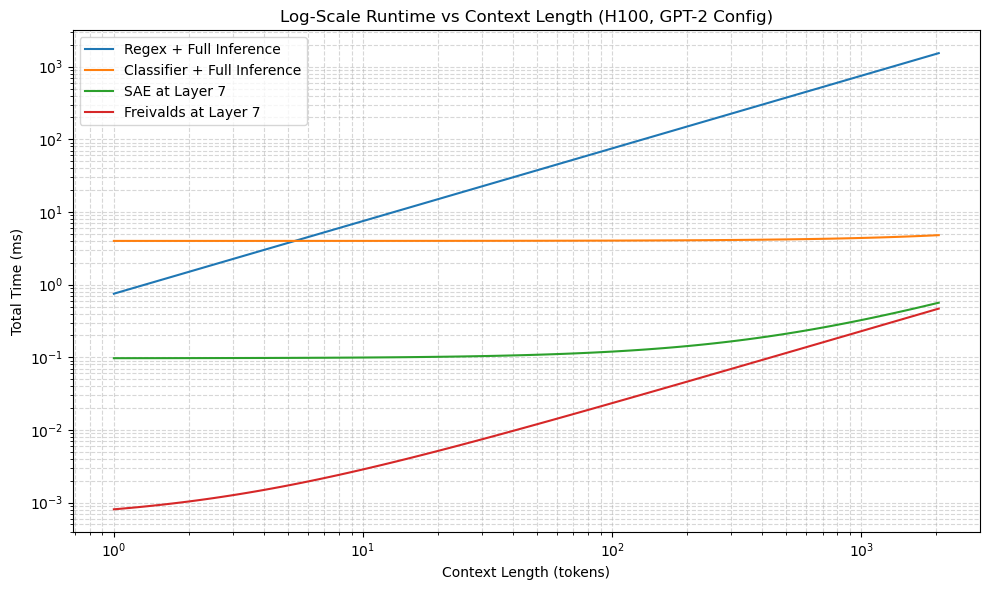

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
C_layer = 6.52e6
L = 12
d_model = 768
throughput = 200e12  # FLOPs/s
regex_per_token = 75 * 1e-5  # 75 regexes * 10us
roberta_fixed = 4e-3
sae_fixed = 0.097e-3
freivalds_fixed = 0.00058e-3

# Context lengths (log scale)
context_lengths = np.logspace(0, 11, num=100, base=2)  # from 1 to 2048

def full_inference(n):
    return (n * L * C_layer) / throughput

def inference_7layers(n):
    return (n * 7 * C_layer) / throughput

regex_times = full_inference(context_lengths) + context_lengths * regex_per_token
classifier_times = full_inference(context_lengths) + roberta_fixed
sae_times = inference_7layers(context_lengths) + sae_fixed
freivalds_times = inference_7layers(context_lengths) + freivalds_fixed

plt.figure(figsize=(10, 6))
plt.loglog(context_lengths, regex_times * 1e3, label="Regex + Full Inference")  # in ms
plt.loglog(context_lengths, classifier_times * 1e3, label="Classifier + Full Inference")
plt.loglog(context_lengths, sae_times * 1e3, label="SAE at Layer 7")
plt.loglog(context_lengths, freivalds_times * 1e3, label="Freivalds at Layer 7")

plt.xlabel("Context Length (tokens)")
plt.ylabel("Total Time (ms)")
plt.title("Log-Scale Runtime vs Context Length (H100, GPT-2 Config)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
# Constants
layers = 12
hidden_dim = 768
mlp_dim = 3072

# Function to calculate FLOPs for a given sequence length n_i
def calculate_flops(n_i):
    # QKV projection FLOPs (fixed per token)
    C_QKV_projection = 3 * hidden_dim**2
    # Attention scores FLOPs
    C_attention_scores = n_i * hidden_dim
    # Weighted sum FLOPs
    C_weighted_sum = n_i * hidden_dim
    # Total attention FLOPs
    C_attn = C_QKV_projection + 2 * C_attention_scores
    # MLP FLOPs
    C_mlp = 2 * hidden_dim * mlp_dim
    # Total FLOPs per token per layer
    C_layer = C_attn + C_mlp
    # Total FLOPs for all layers
    C_total = layers * C_layer
    return C_total

# Example: prompt length = 20, tokens generated = 0 to 19 (20 tokens generated)
prompt_length = 20
flops_per_token = [calculate_flops(prompt_length + i) for i in range(20)]

# Total FLOPs for generating 20 tokens
total_flops = sum(flops_per_token)


In [9]:
flops_per_token

[78225408,
 78243840,
 78262272,
 78280704,
 78299136,
 78317568,
 78336000,
 78354432,
 78372864,
 78391296,
 78409728,
 78428160,
 78446592,
 78465024,
 78483456,
 78501888,
 78520320,
 78538752,
 78557184,
 78575616]

In [10]:
total_flops


1568010240

In [11]:
import re, time
pattern = re.compile(r'your_pattern_here')
s = ' '.join(['word'] * 100)
start = time.perf_counter()
pattern.match(s)
end = time.perf_counter()
print(f"Elapsed time: {(end - start) * 1_000_000:.2f} microseconds")

Elapsed time: 35.43 microseconds
